### facenet-pytorch LFW评估

本笔记本演示了如何针对LFW数据集评估性能。

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training, extract_face
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt # conda install conda-forge::matplotlib-base 


c:\Users\initi\.conda\envs\facenet\Lib\site-packages\tqdm-4.67.0-py3.12.egg\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
data_dir = r'C:\Users\initi\OneDrive\Documents\GitHub\facenet-pytorch\data\lfw\lfw'
pairs_path = r'C:\Users\initi\OneDrive\Documents\GitHub\facenet-pytorch\data\lfw\lfwpairs.txt'

batch_size = 16
epochs = 15
workers = 0 if os.name == 'nt' else 8

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('在该设备上运行: {}'.format(device))

在该设备上运行: cuda


In [13]:
mtcnn = MTCNN(
    image_size=160,
    margin=14,
    device=device,
    selection_method='center_weighted_size'
)

C:\Users\initi\AppData\Roaming\Python\Python312\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state

In [6]:
# 定义输入图像的数据加载器
orig_img_ds = datasets.ImageFolder(data_dir, transform=None)


In [7]:

# 覆盖数据集中的类标签以使用路径，以便在mtcnn批处理中保存输出
orig_img_ds.samples = [
    (p, p)
    for p, _ in orig_img_ds.samples
]

loader = DataLoader(
    orig_img_ds,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

#print(orig_img_ds.samples[0])

828
Dataset ImageFolder
    Number of datapoints: 13233
    Root location: C:\Users\initi\OneDrive\Documents\GitHub\facenet-pytorch\data\lfw\lfw
(250, 250)


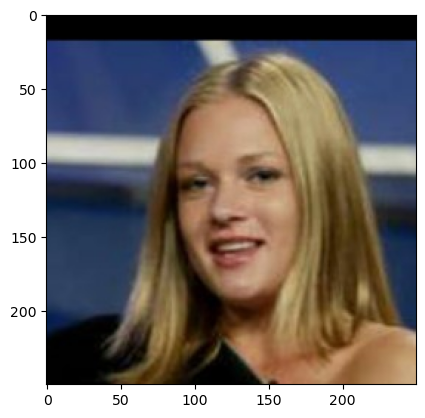

first data poin  <PIL.Image.Image image mode=RGB size=250x250 at 0x29B66C97DD0>


In [8]:
print(len(loader))
print(loader.dataset)
#first_batch = iter(loader)
first_batch = next(iter(loader))
# each iter has 16 (batch_size) of samples
first_data_point = first_batch[0][0]
print(first_data_point.size)
plt.imshow(first_data_point)
plt.show()
print("first data poin ",first_data_point)

In [14]:
crop_paths = []
box_probs = []

for i, (x, b_paths) in enumerate(loader):
    crops = [p.replace(data_dir, data_dir + '_cropped') for p in b_paths]
    mtcnn(x, save_path=crops)
    crop_paths.extend(crops)
    print('\r第 {} 批，共 {} 批'.format(i + 1, len(loader)), end='')

第 828 批，共 828 批

In [10]:
# 为减少GPU内存使用，删除mtcnn
del mtcnn
torch.cuda.empty_cache()

In [15]:
# 从MTCNN裁剪的图像输出创建数据集和数据加载器

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)

embed_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SequentialSampler(dataset)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99609375..0.69921875].


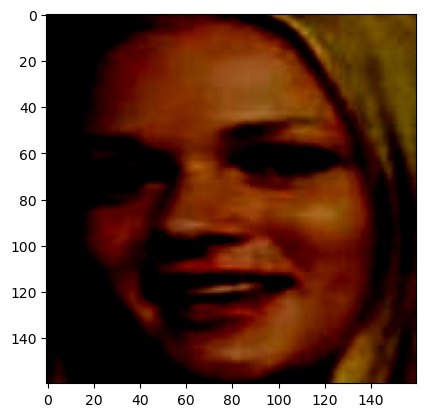

In [18]:
plt.imshow(np.transpose(dataset[0][0], (1,2,0)))

plt.show()

In [19]:
# 加载预训练的Resnet模型
resnet = InceptionResnetV1(
    classify=False,
    pretrained='vggface2'
).to(device)

100%|██████████| 107M/107M [00:04<00:00, 27.0MB/s] 
C:\Users\initi\AppData\Roaming\Python\Python312\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues re

In [20]:
classes = []
embeddings = []
resnet.eval()
with torch.no_grad():
    for xb, yb in embed_loader:
        xb = xb.to(device)
        b_embeddings = resnet(xb)
        b_embeddings = b_embeddings.to('cpu').numpy()
        classes.extend(yb.numpy())
        embeddings.extend(b_embeddings)

In [21]:
embeddings_dict = dict(zip(crop_paths,embeddings))



In [ ]:
print(list(embeddings_dict.items())[0])

#### 使用距离度量评估嵌入，在官方LFW测试集上执行验证。

下一个块中的函数是从`facenet.src.lfw`复制粘贴的。不幸的是，该模块具有从`facenet`绝对导入的绝对导入，因此无法从子模块导入

添加了返回假阳性和假阴性的功能。

In [23]:
from sklearn.model_selection import KFold
from scipy import interpolate

# 以下是从David Sandberg的FaceNet实现中提取的LFW函数
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # 基于余弦相似度的距离
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric

    return dist

def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    is_false_positive = []
    is_false_negative = []

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # 寻找折叠的最佳阈值
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx], _ ,_ = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _, _, _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
        _, _, accuracy[fold_idx], is_fp, is_fn = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
        is_false_positive.extend(is_fp)
        is_false_negative.extend(is_fn)

    return tpr, fpr, accuracy, is_false_positive, is_false_negative

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    is_fp = np.logical_and(predict_issame, np.logical_not(actual_issame))
    is_fn = np.logical_and(np.logical_not(predict_issame), actual_issame)

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc, is_fp, is_fn

def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # 找到使FAR = far_target的阈值
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train)>=far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean

def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far



def evaluate(embeddings, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False):
    # 计算评估指标
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy, fp, fn  = calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    return tpr, fpr, accuracy, val, val_std, far, fp, fn

def add_extension(path):
    if os.path.exists(path+'.jpg'):
        return path+'.jpg'
    elif os.path.exists(path+'.png'):
        return path+'.png'
    else:
        raise RuntimeError('No file "%s" with extension png or jpg.' % path)

def get_paths(lfw_dir, pairs):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
            path1 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[2])))
            issame = True
        elif len(pair) == 4:
            path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
            path1 = add_extension(os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])))
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # 仅在两个路径都存在时添加配对
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('跳过 %d 个图像对' % nrof_skipped_pairs)

    return path_list, issame_list

def read_pairs(pairs_filename):
    pairs = []
    with open(pairs_filename, 'r') as f:
        for line in f.readlines()[1:]:
            pair = line.strip().split()
            pairs.append(pair)
    return np.array(pairs, dtype=object)

In [40]:
print(path_list[0])

C:\Users\initi\OneDrive\Documents\GitHub\facenet-pytorch\data\lfw\lfw_cropped\Abel_Pacheco\Abel_Pacheco_0001.jpg


In [37]:
pairs = read_pairs(pairs_path)
path_list, issame_list = get_paths(data_dir+'_cropped', pairs)
embeddings = np.array([embeddings_dict[path] for path in path_list])

tpr, fpr, accuracy, val, val_std, far, fp, fn = evaluate(embeddings, issame_list)

ValueError: Expect x to not have duplicates

In [15]:
print(accuracy)
np.mean(accuracy)



[0.995      0.995      0.99166667 0.99       0.99       0.99666667
 0.99       0.995      0.99666667 0.99666667]


0.9936666666666666